In [1]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt

In [2]:
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.metrics import confusion_matrix as conf_matrix

In [3]:
filepath = "../data/"
x_train = pd.read_csv(filepath + "X_train.csv")
y_train = pd.read_csv(filepath + "y_train.csv")
x_test = pd.read_csv(filepath + "X_test.csv")

In [4]:
x_train.head()

row_id  series_id  measurement_number  orientation_X  orientation_Y  \
0    0_0          0                   0       -0.75853       -0.63435   
1    0_1          0                   1       -0.75853       -0.63434   
2    0_2          0                   2       -0.75853       -0.63435   
3    0_3          0                   3       -0.75852       -0.63436   
4    0_4          0                   4       -0.75852       -0.63435   

   orientation_Z  orientation_W  angular_velocity_X  angular_velocity_Y  \
0       -0.10488       -0.10597            0.107650            0.017561   
1       -0.10490       -0.10600            0.067851            0.029939   
2       -0.10492       -0.10597            0.007275            0.028934   
3       -0.10495       -0.10597           -0.013053            0.019448   
4       -0.10495       -0.10596            0.005135            0.007652   

   angular_velocity_Z  linear_acceleration_X  linear_acceleration_Y  \
0            0.000767               -0.74857                 2.1030   
1            0.003385                0.33995                 1.5064   
2           -0.005978               -0.26429                 1.5922   
3           -0.008974                0.42684                 1.0993   
4            0.005245               -0.50969                 1.4689   

   linear_acceleration_Z  
0                -9.7532  
1                -9.4128  
2                -8.7267  
3               -10.0960  
4               -10.4410

In [5]:
x_train.shape

(487680, 13)

In [6]:
def pythagoras_3d(x, y, z):
    """
    Returns the sum of the square of cathetus
    """
    h = x ** 2 + y ** 2 + z ** 2
    return h ** 0.5

def quart2euler(x, y, z, w):
    """
    Gets the quartenions and returns the Euler degrees.
    From https://stackoverflow.com/questions/53033620/how-to-convert-euler-angles-to-quaternions-and-get-the-same-euler-angles-back-fr?rq=1
    """
    t0 = +2.0 * (w * x + z * y)
    t1 = +1.0 - 2.0 * (x ** 2 + y ** 2)
    X = math.degrees(math.atan2(t0, t1))
    
    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if (t2 > +1.0) else t2
    t2 = -1.0 if (t2 < -1.0) else t2 ## -1 <= t2 <= 1
    Y = math.degrees(math.asin(t2))
    
    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y ** 2 + z ** 2)
    Z = math.degrees(math.atan2(t3, t4))
    
    return (X, Y, Z)

def mean_abs_diff(s):
    """
    Returns the mean of the absolute differences in the Series
    """
    return np.mean(np.abs(np.diff(s)))

def mean_diff_abs_diff(s):
    """
    Returns the mean of the diff of the absolute differences in the Series
    """
    return np.mean(np.diff(np.abs(np.diff(s))))

In [7]:
def complete_df(adf):
    """
    Creates a dataframe with total angular velocity, total linear acceleration, 
    Euler degrees and mean of absolute differences
    """
    avx, avy, avz = adf['angular_velocity_X'], adf['angular_velocity_Y'], adf['angular_velocity_Z']
    lax, lay, laz = adf['linear_acceleration_X'], adf['linear_acceleration_Y'], adf['linear_acceleration_Z']
    adf["total_angular_velocity"] = pythagoras_3d(avx, avy, avz)
    adf['total_linear_acceleration'] = pythagoras_3d(lax, lay, laz)
    
    cx, cy, cz = [], [], []
    x, y = adf['orientation_X'].tolist(), adf['orientation_Y'].tolist()
    z, w = adf['orientation_Z'].tolist(), adf['orientation_W'].tolist()
    for i in range(len(x)):
        xx, yy, zz = quart2euler(x[i], y[i], z[i], w[i])
        cx.append(xx)
        cy.append(yy)
        cz.append(zz)
    
    adf['euler_x'] = cx
    adf['euler_y'] = cy
    adf['euler_z'] = cz
    
    adf['total_euler'] = (adf['euler_x'] ** 2 + adf['euler_y'] ** 2 + adf['euler_z'] ** 2) ** 5
    
    adf['euler_vs_vel'] = adf['total_euler'] / adf['total_angular_velocity']
    adf['euler_vs_acc'] = adf['total_euler'] / adf['total_linear_acceleration']
    
    rdf = pd.DataFrame()
    
    for col in adf.columns:
        if (col in ['row_id', 'series_id', 'measurement_number']):
            continue
            
        sid = 'series_id'
        grouped = adf.groupby(sid)[col]
        rdf[col + '_mean'] = grouped.mean()
        rdf[col + '_min'] = grouped.min()
        rdf[col + '_max'] = grouped.max()
        rdf[col + '_std'] = grouped.std()
        rdf[col + '_mean_abs_change'] = grouped.apply(mean_abs_diff)
        rdf[col + '_mean_change_of_abs_change'] = grouped.apply(mean_diff_abs_diff)
        rdf[col + '_abs_max'] = grouped.apply(lambda s: np.max(np.abs(s)))
        rdf[col + '_abs_min'] = grouped.apply(lambda s: np.min(np.abs(s)))
    
    return rdf

In [8]:
ntr = complete_df(x_train)
nte = complete_df(x_test)

In [9]:
ntr.head()

orientation_X_mean  orientation_X_min  orientation_X_max  \
series_id                                                             
0                   -0.758666           -0.75953           -0.75822   
1                   -0.958606           -0.95896           -0.95837   
2                   -0.512057           -0.51434           -0.50944   
3                   -0.939169           -0.93968           -0.93884   
4                   -0.891301           -0.89689           -0.88673   

           orientation_X_std  orientation_X_mean_abs_change  \
series_id                                                     
0                   0.000363                       0.000015   
1                   0.000151                       0.000023   
2                   0.001377                       0.000041   
3                   0.000227                       0.000026   
4                   0.002955                       0.000080   

           orientation_X_mean_change_of_abs_change  orientation_X_abs_max  \
series_id                                                                   
0                                     2.380952e-07                0.75953   
1                                    -4.761905e-07                0.95896   
2                                     0.000000e+00                0.51434   
3                                    -6.349206e-07                0.93968   
4                                     7.936508e-08                0.89689   

           orientation_X_abs_min  orientation_Y_mean  orientation_Y_min  ...  \
series_id                                                                ...   
0                        0.75822           -0.634008           -0.63456  ...   
1                        0.95837            0.241867            0.24074  ...   
2                        0.50944           -0.846171           -0.84779  ...   
3                        0.93884            0.310140            0.30943  ...   
4                        0.88673            0.428144            0.41646  ...   

           euler_vs_vel_abs_max  euler_vs_vel_abs_min  euler_vs_acc_mean  \
series_id                                                                  
0                  3.659342e+24          2.385176e+23       3.925644e+21   
1                  7.461681e+23          5.253730e+22       1.548891e+21   
2                  1.092963e+25          6.385567e+23       1.088309e+22   
3                  1.190031e+24          3.298844e+22       1.760319e+21   
4                  2.350530e+23          8.883627e+22       2.140524e+21   

           euler_vs_acc_min  euler_vs_acc_max  euler_vs_acc_std  \
series_id                                                         
0              3.084655e+21      5.449093e+21      4.277943e+20   
1              8.921258e+20      2.586452e+21      2.962051e+20   
2              8.572890e+21      1.611629e+22      1.078109e+21   
3              8.227079e+20      8.343524e+21      9.367157e+20   
4              1.831932e+21      2.644263e+21      1.760533e+20   

           euler_vs_acc_mean_abs_change  \
series_id                                 
0                          2.831642e+20   
1                          2.172031e+20   
2                          7.821741e+20   
3                          4.771048e+20   
4                          1.145764e+20   

           euler_vs_acc_mean_change_of_abs_change  euler_vs_acc_abs_max  \
series_id                                                                 
0                                    1.509215e+18          5.449093e+21   
1                                   -5.501222e+18          2.586452e+21   
2                                   -1.067040e+19          1.611629e+22   
3                                   -4.261532e+18          8.343524e+21   
4                                   -2.300218e+17          2.644263e+21   

           euler_vs_acc_abs_min  
series_id                        
0                  3.084655e+21  
1                  8.921258e+20  
2  

In [10]:
y_train.head()

series_id  group_id        surface
0          0        13  fine_concrete
1          1        31       concrete
2          2        20       concrete
3          3        31       concrete
4          4        22     soft_tiles

In [11]:
le = LE()
y_train['surface'] = le.fit_transform(y_train['surface'])

In [12]:
ntr.fillna(0, inplace=True)
nte.fillna(0, inplace=True)
ntr.replace(-np.inf, 0, inplace=True)
nte.replace(-np.inf, 0, inplace=True)
ntr.replace(+np.inf, 0, inplace=True)
nte.replace(+np.inf, 0, inplace=True)

In [13]:
ntr.head()

orientation_X_mean  orientation_X_min  orientation_X_max  \
series_id                                                             
0                   -0.758666           -0.75953           -0.75822   
1                   -0.958606           -0.95896           -0.95837   
2                   -0.512057           -0.51434           -0.50944   
3                   -0.939169           -0.93968           -0.93884   
4                   -0.891301           -0.89689           -0.88673   

           orientation_X_std  orientation_X_mean_abs_change  \
series_id                                                     
0                   0.000363                       0.000015   
1                   0.000151                       0.000023   
2                   0.001377                       0.000041   
3                   0.000227                       0.000026   
4                   0.002955                       0.000080   

           orientation_X_mean_change_of_abs_change  orientation_X_abs_max  \
series_id                                                                   
0                                     2.380952e-07                0.75953   
1                                    -4.761905e-07                0.95896   
2                                     0.000000e+00                0.51434   
3                                    -6.349206e-07                0.93968   
4                                     7.936508e-08                0.89689   

           orientation_X_abs_min  orientation_Y_mean  orientation_Y_min  ...  \
series_id                                                                ...   
0                        0.75822           -0.634008           -0.63456  ...   
1                        0.95837            0.241867            0.24074  ...   
2                        0.50944           -0.846171           -0.84779  ...   
3                        0.93884            0.310140            0.30943  ...   
4                        0.88673            0.428144            0.41646  ...   

           euler_vs_vel_abs_max  euler_vs_vel_abs_min  euler_vs_acc_mean  \
series_id                                                                  
0                  3.659342e+24          2.385176e+23       3.925644e+21   
1                  7.461681e+23          5.253730e+22       1.548891e+21   
2                  1.092963e+25          6.385567e+23       1.088309e+22   
3                  1.190031e+24          3.298844e+22       1.760319e+21   
4                  2.350530e+23          8.883627e+22       2.140524e+21   

           euler_vs_acc_min  euler_vs_acc_max  euler_vs_acc_std  \
series_id                                                         
0              3.084655e+21      5.449093e+21      4.277943e+20   
1              8.921258e+20      2.586452e+21      2.962051e+20   
2              8.572890e+21      1.611629e+22      1.078109e+21   
3              8.227079e+20      8.343524e+21      9.367157e+20   
4              1.831932e+21      2.644263e+21      1.760533e+20   

           euler_vs_acc_mean_abs_change  \
series_id                                 
0                          2.831642e+20   
1                          2.172031e+20   
2                          7.821741e+20   
3                          4.771048e+20   
4                          1.145764e+20   

           euler_vs_acc_mean_change_of_abs_change  euler_vs_acc_abs_max  \
series_id                                                                 
0                                    1.509215e+18          5.449093e+21   
1                                   -5.501222e+18          2.586452e+21   
2                                   -1.067040e+19          1.611629e+22   
3                                   -4.261532e+18          8.343524e+21   
4                                   -2.300218e+17          2.644263e+21   

           euler_vs_acc_abs_min  
series_id                        
0                  3.084655e+21  
1                  8.921258e+20  
2  

In [14]:
ntr.shape

(3810, 144)

In [15]:
nte.shape

(3816, 144)

In [16]:
y_train.shape

(3810, 3)

### Balance classes missing

In [17]:
from imblearn.over_sampling import RandomOverSampler as ROS

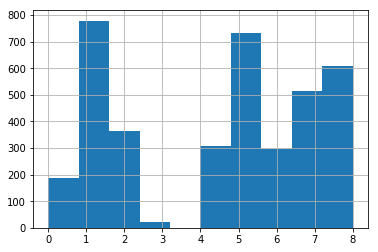

In [18]:
y_train['surface'].hist()

(array([779., 779., 779., 779.,   0., 779., 779., 779., 779., 779.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

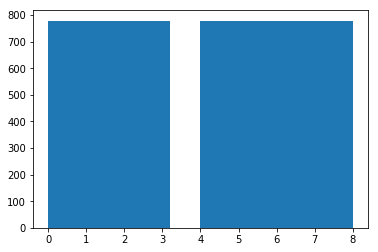

In [19]:
ros = ROS(random_state=71)
rntr, ry_train = ros.fit_resample(ntr, y_train['surface'])
plt.hist(ry_train)

# Well......... We've balanced and generated grouped data.... 

**Lets then see some plots about it :D**

In [20]:
ntr.head(10)

orientation_X_mean  orientation_X_min  orientation_X_max  \
series_id                                                             
0                   -0.758666          -0.759530          -0.758220   
1                   -0.958606          -0.958960          -0.958370   
2                   -0.512057          -0.514340          -0.509440   
3                   -0.939169          -0.939680          -0.938840   
4                   -0.891301          -0.896890          -0.886730   
5                    0.464712           0.464030           0.465450   
6                   -0.402356          -0.405750          -0.398560   
7                   -0.925909          -0.926190          -0.925590   
8                    0.012041           0.009159           0.018242   
9                    0.789137           0.751010           0.824630   

           orientation_X_std  orientation_X_mean_abs_change  \
series_id                                                     
0                   0.000363                       0.000015   
1                   0.000151                       0.000023   
2                   0.001377                       0.000041   
3                   0.000227                       0.000026   
4                   0.002955                       0.000080   
5                   0.000315                       0.000045   
6                   0.002120                       0.000057   
7                   0.000136                       0.000026   
8                   0.002931                       0.000073   
9                   0.021568                       0.000580   

           orientation_X_mean_change_of_abs_change  orientation_X_abs_max  \
series_id                                                                   
0                                     2.380952e-07               0.759530   
1                                    -4.761905e-07               0.958960   
2                                     0.000000e+00               0.514340   
3                                    -6.349206e-07               0.939680   
4                                     7.936508e-08               0.896890   
5                                     4.761905e-07               0.465450   
6                                     3.968254e-07               0.405750   
7                                    -7.936508e-08               0.926190   
8                                    -6.333333e-07               0.018242   
9                                     7.936508e-07               0.824630   

           orientation_X_abs_min  orientation_Y_mean  orientation_Y_min  ...  \
series_id                                                                ...   
0                       0.758220           -0.634008           -0.63456  ...   
1                       0.958370            0.241867            0.24074  ...   
2                       0.509440           -0.846171           -0.84779  ...   
3                       0.938840            0.310140            0.30943  ...   
4                       0.886730            0.428144            0.41646  ...   
5                       0.464030           -0.872496           -0.87288  ...   
6                       0.398560           -0.903141           -0.90498  ...   
7                       0.925590            0.347657            0.34670  ...   
8                       0.009159           -0.988922           -0.98894  ...   
9                       0.751010           -0.594258           -0.64267  ...   

           euler_vs_vel_abs_max  euler_vs_vel_abs_min  euler_vs_acc_mean  \
series_id                                                                  
0                  3.659342e+24          2.385176e+23       3.925644e+21   
1                  7.461681e+23          5.253730e+22       1.548891e+21   
2                  1.092963e+25          6.385567e+23       1.088309e+22   
3                  1.190031e+24          3.298844e+22       1.760319e+21   
4                  2.350530e+23          8.883627e+22      

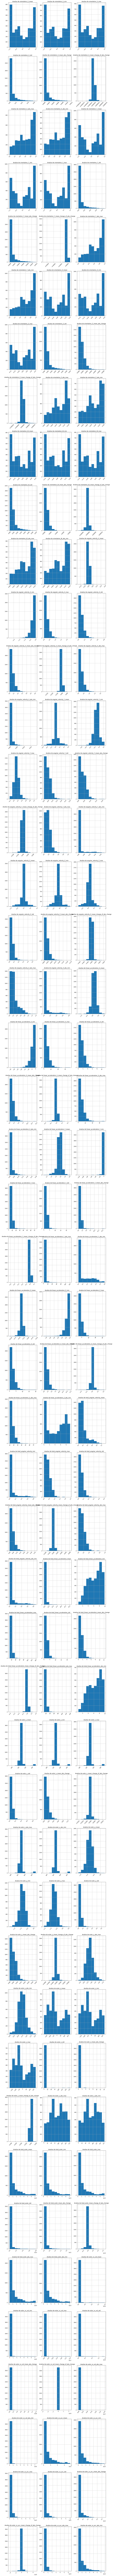

In [21]:
plt.figure(figsize=(16, 3 * len(ntr.columns)))

for i in range(len(ntr.columns)):
    colx = ntr.columns[i]
    if (colx == 'series_id'):
        continue
    
    plt.subplot(round(len(ntr.columns) / 3), 3, i + 1)
    plt.title("Analise de %s" % colx)
    plt.xticks(rotation = 45)
    ntr[colx].hist()
    
plt.show()

# Now its time for the stars of this show: THE PREDICTIONS

In [22]:
from sklearn.tree import DecisionTreeClassifier as DTree
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.model_selection import GridSearchCV as GSearchCV
from sklearn.ensemble import AdaBoostClassifier as AdaBoostC

In [23]:
from sklearn.metrics import make_scorer, accuracy_score
acc = make_scorer(accuracy_score)

In [24]:
dtree_parameters = {
    'max_depth': [12, 24, 36, 50],
    'min_samples_leaf': [5, 10, 15, 25],
    'max_features': ['sqrt', 'log2', None]
}
decision_tree_model = DTree()
decision_tree = GSearchCV(decision_tree_model, dtree_parameters, cv=10, n_jobs=-1, scoring=acc)
decision_tree.fit(rntr, ry_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [12, 24, 36, 50], 'min_samples_leaf': [5, 10, 15, 25], 'max_features': ['sqrt', 'log2', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(accuracy_score), verbose=0)

In [25]:
decision_tree.best_score_

0.8870346598202824

### LET US SEE THAT TREEEEEEEEEEE

In [26]:
best_tree = decision_tree.best_estimator_
best_tree

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=36,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [27]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(best_tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.838867 to fit



In [28]:
pred = decision_tree.predict(nte)
surfaces = le.inverse_transform(pred)

In [29]:
out = pd.DataFrame({ 'series_id': range(len(surfaces)), 'surface': surfaces })
out.to_csv(filepath + 'subm1.csv', index = False)

In [30]:
out.head()

series_id                 surface
0          0  hard_tiles_large_space
1          1                concrete
2          2                   tiled
3          3              soft_tiles
4          4              soft_tiles

In [31]:
params_ada = {
    'base_estimator': [DTree(max_depth=5), DTree(max_depth=10), DTree(max_depth=15)],
    'n_estimators': [25, 50, 75, 100],
}
ada = AdaBoostC()
ada_boost = GSearchCV(ada, params_ada, cv = 10, n_jobs = -1, scoring = acc)
ada_boost.fit(rntr, ry_train)
best_ada = ada_boost.best_estimator_

In [32]:
pred = ada_boost.predict(nte)
surfaces = le.inverse_transform(pred)

In [33]:
ada_boost.best_score_

0.9597774925117672

In [34]:
out = pd.DataFrame({ 'series_id': range(len(surfaces)), 'surface':surfaces })
out.to_csv(filepath + 'submi2.csv', index = False)

In [35]:
params_mlp = {
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'alpha': [1e-4, 0.001, 0.01, 0.1, 1],
    'max_iter': [75, 100, 150, 200, 250]
}
mlp = MLP()
mlpc = GSearchCV(mlp, params_mlp, cv = 10, n_jobs = -1, scoring = acc)
mlpc.fit(rntr, ry_train)

/home/juliobarreto/anaconda2/envs/careercon/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1], 'max_iter': [75, 100, 150, 200, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(accuracy_score), verbose=0)

In [36]:
pred = mlpc.predict(nte)
surfaces = le.inverse_transform(pred)

In [37]:
out = pd.DataFrame({ 'series_id': range(len(surfaces)), 'surface':surfaces })
out.to_csv(filepath + 'submi3.csv', index = False)

In [38]:
mlpc.best_score_

0.3313364712594494

In [39]:
ada_boost.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=75, random_state=None)

In [40]:
decision_tree.best_score_

0.8870346598202824

In [41]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',
                          cmap=plt.cm.Blues):
    # Função importada dos exemplos do SKLearn
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### XGBOOST

In [42]:
import xgboost as xgb

In [53]:
xgbmodel = xgb.XGBClassifier(n_jobs = -1)
xgbparams = {
    'max_depth': [3, 5, 7, 10, 15],
    'n_estimators': [50, 75, 100, 150, 250]
    
}
xgbgrid = GSearchCV(xgbmodel, xgbparams, cv = 10, n_jobs = -1, scoring = acc)
xgbgrid.fit(rntr, ry_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7, 10, 15], 'n_estimators': [50, 75, 100, 150, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(accuracy_score), verbose=0)

In [57]:
pred = xgbgrid.predict(nte.as_matrix())
surfaces = le.inverse_transform(pred)

/home/juliobarreto/anaconda2/envs/careercon/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [59]:
xgbgrid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=250,
       n_jobs=-1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [60]:
out = pd.DataFrame({ 'series_id': range(len(surfaces)), 'surface':surfaces })
out.to_csv(filepath + 'submi4.csv', index = False)